# 1. Data loading and model training.

In [1]:
# Import the necessary libraries, set the random seed, and configure some hyperparameters.
# “'AM', 'EM', 'QY', and 'LGAC' represent the absorption wavelength, emission wavelength, quantum yield, and molar absorptivity, respectively.”

import pandas as pd
import numpy as np
import os
import random
import copy
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
    print('use GPU')
    device = 'cuda'
else:
    print('use CPU')
    device = 'cpu'

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats = atom_featurizer.feat_size('hv')
e_feats = bond_featurizer.feat_size('he')
print("n_feats", n_feats, "e_feats", e_feats)

graph_feat_size = 256
n_tasks = 4
dropout_g = 0.4
dropout_f = 0.5
dropout_l = 0.4

E:\Anaconda\envs\dye37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


use GPU
n_feats 39 e_feats 10


In [2]:
# Generate training and testing datasets.
def load_data_with_fp(data, fp_data, name, load):
    dataset = MoleculeCSVDataset(data,
                                 smiles_to_graph=smiles_to_bigraph,
                                 node_featurizer=atom_featurizer,
                                 edge_featurizer=bond_featurizer,
                                 smiles_column='SMILES',
                                 cache_file_path=str(name)+'_dataset_xanthene_dir-training.bin',
                                 task_names=['AM','EM','QY','LGAC'],
                                 load=load, init_mask=True, n_jobs=1
                                )

    combined_data = []
    for i, data_tuple in enumerate(dataset):
        if len(data_tuple) == 3:
            smiles, graph, label = data_tuple
            mask = None
        else:
            smiles, graph, label, mask = data_tuple
        fp = torch.tensor(fp_data[i], dtype=torch.float32)
        combined_data.append((graph, fp, label, mask))
    return combined_data

In [3]:
# Fingerprint data loading.
def load_fingerprints(fp_file):
    df = pd.read_csv(fp_file, header=None)
    return torch.tensor(df.values, dtype=torch.float32)
    
train_data = pd.read_csv('./dataset_xanthene/random_train_1.csv')
test_data = pd.read_csv('./dataset_xanthene/random_test_1.csv')

scaler = StandardScaler()
train_data[['AM', 'EM', 'QY', 'LGAC']] = scaler.fit_transform(train_data[['AM', 'EM', 'QY', 'LGAC']])
test_data[['AM', 'EM', 'QY', 'LGAC']] = scaler.transform(test_data[['AM', 'EM', 'QY', 'LGAC']])

train_fp = load_fingerprints('./dataset_xanthene/random_train_1_morgan.csv')
test_fp = load_fingerprints('./dataset_xanthene/random_test_1_morgan.csv')

train_datasets = load_data_with_fp(train_data, train_fp, 'train', True)
test_datasets = load_data_with_fp(test_data, test_fp, 'test', True)

Loading previously saved dgl graphs...
Loading previously saved dgl graphs...


E:\Anaconda\envs\dye37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [4]:
# Define a multi-task model MTATFP
class GraphFingerprintsModel(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, fp_size, 
                 graph_feat_size=256, num_layers=2, num_timesteps=2, 
                 n_tasks=4, dropout_g=0, dropout_f=0, dropout_l=0):
        super(GraphFingerprintsModel, self).__init__()
        
        # Characterization of dye molecules.
        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=num_layers,
                                  graph_feat_size=graph_feat_size,
                                  dropout=dropout_g)
        self.readout = AttentiveFPReadout(feat_size=graph_feat_size,
                                          num_timesteps=num_timesteps,
                                          dropout=dropout_g)

        # Characterization of solvent molecules.
        self.fp_fc = nn.Sequential(
            nn.Linear(fp_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_f),
            nn.Linear(256, graph_feat_size)
        )
        
        # Combine dye features and solvent features.
        self.predict = nn.Sequential(
            nn.Dropout(dropout_l),
            nn.Linear(graph_feat_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, n_tasks)
        )
        
    def forward(self, g, node_feats, edge_feats, fingerprints, get_node_weight=False):
        if edge_feats is None or 'he' not in g.edata.keys():
            num_edges = g.number_of_edges()
            edge_feats = torch.zeros((num_edges, edge_feats.size(1))).to(g.device)
        
        node_feats = self.gnn(g, node_feats, edge_feats)
        
        if get_node_weight:
            graph_feats, node_weights = self.readout(g, node_feats, get_node_weight)
            fp_feats = self.fp_fc(fingerprints)
            combined_feats = torch.cat([graph_feats, fp_feats], dim=1)
            return self.predict(combined_feats), node_weights
        else:
            graph_feats = self.readout(g, node_feats, get_node_weight)
            fp_feats = self.fp_fc(fingerprints)
            combined_feats = torch.cat([graph_feats, fp_feats], dim=1)
            return self.predict(combined_feats)


In [5]:
# Custom dataset class.
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Collate function for data loading.
def collate_fn(batch):
    graphs, fps, labels, masks = zip(*batch)
    graphs = dgl.batch(graphs)
    fps = torch.stack(fps)
    labels = torch.stack(labels)
    masks = torch.stack(masks) if masks[0] is not None else None
    return graphs, fps, labels, masks

In [6]:
# Training function.
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for graphs, fps, labels, masks in dataloader:

        graphs = graphs.to(device)
        fps = fps.to(device)
        labels = labels.to(device)
        masks = masks.to(device) if masks is not None else None

        node_feats = graphs.ndata['hv']
        edge_feats = graphs.edata['he']

        predictions = model(graphs, node_feats, edge_feats, fps)

        if masks is not None:
            loss = (criterion(predictions, labels) * masks).mean()
        else:
            loss = criterion(predictions, labels)
        
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

In [7]:
# Main function.
def main():
    node_feat_size = n_feats
    edge_feat_size = e_feats
    graph_feat_size = 256
    num_layers = 2
    num_timesteps = 2
    fp_size = train_fp.shape[1]
    n_tasks = 4
    dropout_g = 0.4
    dropout_f = 0.5
    dropout_l = 0.4
    batch_size = 32
    learning_rate = 1e-3
    epochs = 200
    patience = 20

    # Initialize the model.
    model = GraphFingerprintsModel(node_feat_size=node_feat_size,
                                   edge_feat_size=edge_feat_size,
                                   graph_feat_size=graph_feat_size,
                                   num_layers=num_layers,
                                   num_timesteps=num_timesteps,
                                   fp_size=fp_size,
                                   n_tasks=n_tasks,
                                   dropout_g=dropout_g,
                                   dropout_f=dropout_f,
                                   dropout_l=dropout_l).to(device)

    # Data loading.
    train_dataset = MolecularDataset(train_datasets)
    test_dataset = MolecularDataset(test_datasets)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

    # Loss function and optimizer.
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_since_improvement = 0

    for epoch in range(1, epochs + 1):
        train_loss = train_model(model, train_loader, optimizer, criterion)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for graphs, fps, labels, masks in test_loader:
                graphs = graphs.to(device)
                fps = fps.to(device)
                labels = labels.to(device)
                if masks is not None:
                    masks = masks.to(device)

                node_feats = graphs.ndata['hv']
                edge_feats = graphs.edata['he']

                predictions = model(graphs, node_feats, edge_feats, fps)
                if masks is not None:
                    loss = (criterion(predictions, labels) * masks).mean()
                else:
                    loss = criterion(predictions, labels)

                val_loss += loss.item()

            val_loss /= len(test_loader)
            print(f'Epoch {epoch}, test Loss: {val_loss:.4f}')

            # Early stopping strategy.
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_since_improvement = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                epochs_since_improvement += 1
                if epochs_since_improvement >= patience:
                    print("Early stopping triggered.")
                    break

    # Save the best model.
    torch.save(best_model_wts, 'model_xanthene_dir-training.pth')
    print('Model parameters saved')

if __name__ == '__main__':
    main()

Epoch 1, Train Loss: 0.6468
Epoch 1, test Loss: 0.6424
Epoch 2, Train Loss: 0.5702
Epoch 2, test Loss: 0.5544
Epoch 3, Train Loss: 0.5153
Epoch 3, test Loss: 0.4943
Epoch 4, Train Loss: 0.4837
Epoch 4, test Loss: 0.4719
Epoch 5, Train Loss: 0.4457
Epoch 5, test Loss: 0.4467
Epoch 6, Train Loss: 0.4036
Epoch 6, test Loss: 0.4291
Epoch 7, Train Loss: 0.3600
Epoch 7, test Loss: 0.4155
Epoch 8, Train Loss: 0.3472
Epoch 8, test Loss: 0.4249
Epoch 9, Train Loss: 0.3308
Epoch 9, test Loss: 0.3741
Epoch 10, Train Loss: 0.2961
Epoch 10, test Loss: 0.3381
Epoch 11, Train Loss: 0.2761
Epoch 11, test Loss: 0.3234
Epoch 12, Train Loss: 0.2485
Epoch 12, test Loss: 0.3300
Epoch 13, Train Loss: 0.2453
Epoch 13, test Loss: 0.3224
Epoch 14, Train Loss: 0.2191
Epoch 14, test Loss: 0.3001
Epoch 15, Train Loss: 0.2138
Epoch 15, test Loss: 0.2888
Epoch 16, Train Loss: 0.2008
Epoch 16, test Loss: 0.2776
Epoch 17, Train Loss: 0.1878
Epoch 17, test Loss: 0.2706
Epoch 18, Train Loss: 0.1755
Epoch 18, test Loss:

# 2. The model's results on the training and test sets.

In [8]:
device = 'cpu'
train_dataset = MolecularDataset(train_datasets)
test_dataset = MolecularDataset(test_datasets)
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [9]:
fp_size = train_fp.shape[1]
# Initialize the model.
model = GraphFingerprintsModel(node_feat_size=n_feats,
                               edge_feat_size=e_feats,
                               graph_feat_size=256,
                               num_layers=2,
                               num_timesteps=2,
                               fp_size=fp_size,
                               n_tasks=4,
                               dropout_g=0.4,
                               dropout_f=0.5,
                               dropout_l=0.4).to(device)

# Load saved model parameters.
model.load_state_dict(torch.load('model_xanthene_dir-training.pth', map_location=device))
model.eval()

GraphFingerprintsModel(
  (gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=39, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=49, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0.4, inplace=False)
        (1): Linear(in_features=512, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0.4, inplace=False)
          (1): Linear(in_features=256, out_features=256, bias=True)
        )
        (gru): GRUCell(256, 256)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0.4, inplace=False)
          (1): Linear(in_features=512, out_f

In [10]:
# Prediction.
def predict(model, dataloader):
    all_predictions = []
    with torch.no_grad():
        for graphs, fps, _, _ in dataloader:
            graphs = graphs.to(device)
            fps = fps.to(device)

            node_feats = graphs.ndata['hv']
            edge_feats = graphs.edata['he']

            predictions = model(graphs, node_feats, edge_feats, fps)
            all_predictions.append(predictions.cpu().numpy())

    return np.vstack(all_predictions)

train_predictions = predict(model, train_loader)
test_predictions = predict(model, test_loader)

# Save prediction results to a CSV file.
def save_predictions(predictions, file_name):
    df = pd.DataFrame(predictions, columns=['AM','EM','QY','LGAC'])
    df.to_csv(file_name, index=False)

# After prediction, reverse the normalization of the predicted results.
def reverse_standardization(predictions, scaler):
    return scaler.inverse_transform(predictions)

train_scale_predictions = reverse_standardization(train_predictions, scaler)
test_scale_predictions = reverse_standardization(test_predictions, scaler)

save_predictions(train_scale_predictions, 'train_predictions_xanthene_dir-training.csv')
save_predictions(test_scale_predictions, 'test_predictions_xanthene_dir-training.csv')
print("Predictions saved to train_predictions.csv")
print("Predictions saved to test_predictions.csv")

Predictions saved to train_predictions.csv
Predictions saved to test_predictions.csv


In [11]:
# Evaluation function.
def compute_metrics(pred_file, true_file, tasks=['AM', 'EM', 'QY', 'LGAC']):

    predictions = pd.read_csv(pred_file)  # 预测值
    true_labels = pd.read_csv(true_file)  # 真实值
    
    # Replace missing labels with NaN.
    true_labels.replace([None, ''], np.nan, inplace=True)
    predictions.replace([None, ''], np.nan, inplace=True)
    metrics = {}

    for task in tasks:
        true_task = true_labels[task]
        pred_task = predictions[task]

        mask = ~true_task.isna()
        true_task = true_task[mask]
        pred_task = pred_task[mask]

        mae = mean_absolute_error(true_task, pred_task)
        rmse = np.sqrt(mean_squared_error(true_task, pred_task))
        r2 = r2_score(true_task, pred_task)

        metrics[task] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"Task: {task} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    all_true = true_labels[tasks].to_numpy().flatten()
    all_pred = predictions[tasks].to_numpy().flatten()

    mask = ~np.isnan(all_true)
    all_true = all_true[mask]
    all_pred = all_pred[mask]

    overall_mae = mean_absolute_error(all_true, all_pred)
    overall_rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    overall_r2 = r2_score(all_true, all_pred)

    metrics['Overall'] = {'MAE': overall_mae, 'RMSE': overall_rmse, 'R2': overall_r2}

    print(f"Overall - MAE: {overall_mae:.4f}, RMSE: {overall_rmse:.4f}, R2: {overall_r2:.4f}")
    
    return metrics

In [12]:
# Calculate performance metrics for the training and test sets.
train_metrics = compute_metrics('train_predictions_xanthene_dir-training.csv', './dataset_xanthene/random_train_1.csv')
test_metrics = compute_metrics('test_predictions_xanthene_dir-training.csv', './dataset_xanthene/random_test_1.csv')

Task: AM - MAE: 7.1060, RMSE: 9.6609, R2: 0.9891
Task: EM - MAE: 6.7177, RMSE: 9.2033, R2: 0.9871
Task: QY - MAE: 0.0528, RMSE: 0.0695, R2: 0.9394
Task: LGAC - MAE: 0.0707, RMSE: 0.0968, R2: 0.9125
Overall - MAE: 4.1828, RMSE: 7.3204, R2: 0.9994
Task: AM - MAE: 12.8457, RMSE: 20.1304, R2: 0.9540
Task: EM - MAE: 13.1232, RMSE: 19.8816, R2: 0.9283
Task: QY - MAE: 0.1101, RMSE: 0.1591, R2: 0.7275
Task: LGAC - MAE: 0.1700, RMSE: 0.2593, R2: 0.4731
Overall - MAE: 8.0348, RMSE: 15.6945, R2: 0.9971


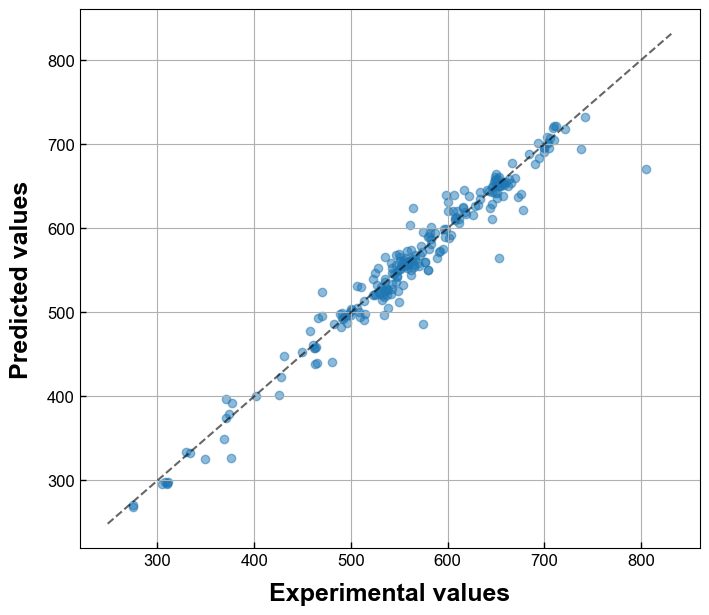

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

experiment_data = pd.read_csv('./dataset_xanthene/random_test_1.csv')
prediction_data = pd.read_csv('test_predictions_xanthene_dir-training.csv')

plt.figure(figsize=(8, 7))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.scatter(experiment_data['AM'], prediction_data['AM'], alpha=0.5)
plt.xlabel('Experimental values', labelpad=10, fontweight='bold')
plt.ylabel('Predicted values', labelpad=10, fontweight='bold')
plt.tick_params(axis='x', direction='in', length=4, width=1)
plt.tick_params(axis='y', direction='in', length=4, width=1)

# 获取坐标轴范围
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [xmin, xmax], color='black', linestyle='--',alpha=0.6)

plt.grid(True)
plt.show()

# 3. Visualization of atomic weights.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
import dgl
import matplotlib
import matplotlib.cm as cm
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

def draw(mol_id, dataset, timestep):
    g, fps, label, _ = dataset[mol_id]
    g = dgl.batch([g])
    fps = fps.unsqueeze(0)
    atom_feats, bond_feats = g.ndata.pop('hv'), g.edata.pop('he')
    preds, atom_weights1 = model(g, atom_feats, bond_feats, fps, get_node_weight=True)
    assert timestep < len(atom_weights1)
    atom_weights1 = atom_weights1[timestep]
    min_value = torch.min(atom_weights1)
    max_value = torch.max(atom_weights1)
    atom_weights = (atom_weights1 - min_value) / (max_value - min_value)
    c=atom_weights.detach().cpu().numpy().flatten().tolist()
    norm = matplotlib.colors.Normalize(vmin=0,vmax=(sum(c)/len(c)))
    cmap = cm.get_cmap('summer_r') # viridis,magma,inferno,cividis,coolwarm,plasma,summer_r
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(g.number_of_nodes())}
    plt_colors._A = [] 
    cb = plt.colorbar(plt_colors) 
    cb.set_ticks([]) 
    
    smiless = train_data['SMILES']
    smiles=smiless[mol_id]
    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
    
    drawer.SetFontSize(1)
    op = drawer.drawOptions().addAtomIndices=True
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(g.number_of_nodes()),highlightBonds=[],
    highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    # 保存SVG图像
    svg_file_path = f"molecule_{mol_id}.svg"  # 设置文件名
    with open(svg_file_path, 'w') as f:
        f.write(svg)
    display(SVG(svg))
    avg_all_weight = sum(atom_weights)/len(atom_weights)
    list_a=[]
    num=0
    for i in atom_weights:
        list_a.append([i,num])
        num+=1
    return smiles,label,preds,list_a,avg_all_weight

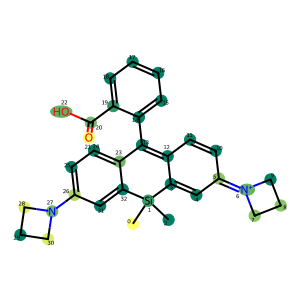

('C[Si]1(C)C2=CC(=[N+]3CCC3)C=CC2=C(c2ccccc2C(=O)O)c2ccc(N3CCC3)cc21',
 tensor([0.8693, 0.5645, 0.0000, 0.0000]),
 tensor([[ 0.2590,  0.1367, -0.2177,  0.0099]], grad_fn=<AddmmBackward0>),
 [[tensor([0.], grad_fn=<UnbindBackward0>), 0],
  [tensor([0.2476], grad_fn=<UnbindBackward0>), 1],
  [tensor([0.7879], grad_fn=<UnbindBackward0>), 2],
  [tensor([1.], grad_fn=<UnbindBackward0>), 3],
  [tensor([0.7186], grad_fn=<UnbindBackward0>), 4],
  [tensor([0.1410], grad_fn=<UnbindBackward0>), 5],
  [tensor([0.1927], grad_fn=<UnbindBackward0>), 6],
  [tensor([0.1479], grad_fn=<UnbindBackward0>), 7],
  [tensor([0.1479], grad_fn=<UnbindBackward0>), 8],
  [tensor([0.3363], grad_fn=<UnbindBackward0>), 9],
  [tensor([0.3934], grad_fn=<UnbindBackward0>), 10],
  [tensor([0.3111], grad_fn=<UnbindBackward0>), 11],
  [tensor([0.5221], grad_fn=<UnbindBackward0>), 12],
  [tensor([0.3671], grad_fn=<UnbindBackward0>), 13],
  [tensor([0.4442], grad_fn=<UnbindBackward0>), 14],
  [tensor([0.3916], grad_fn=<Unbin

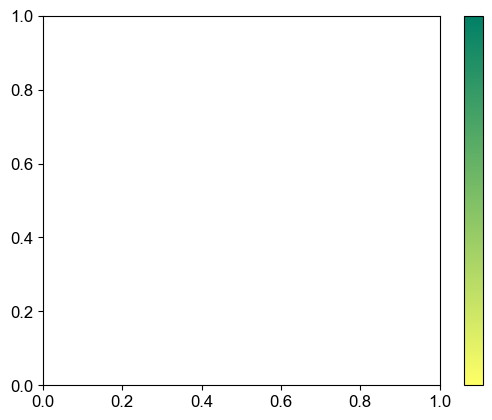

In [15]:
draw(919,train_datasets, 0)